In [1]:
import params
import model
import matplotlib.pyplot as plt
import jax
import jax.numpy as np

In [2]:
# simulation
tissue_size = (12.5, 12.5)  #cm
dx = 0.025  # 1/cm
dt = 0.01
shape = (int(tissue_size[0] / dx), int(tissue_size[1] / dx))
length = 10  # ms
d = 0.05  # cm/ms

# stimuli
field = np.zeros(shape)
field = jax.ops.index_update(field, jax.ops.index[0:20], .8)
s1 = {
    "field": field,
    "start": 0,
    "duration": 2,
    "period": 0  # non-cyclic
}

field2 = np.zeros(shape)
field2 = jax.ops.index_update(field, jax.ops.index[:, -20:], .5)
s2 = {
    "field": field2,
    "start": 200,
    "duration": 2,
    "period": 0  # non-cyclic
}

field3 = np.zeros(shape)
field2 = jax.ops.index_update(field, jax.ops.index[40:60], .5)
s3 = {
    "field": field3,
    "start": 360,
    "duration": 15,
    "period": 0  # non-cyclic
}

/home/epignatelli/repos/jax/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [6]:
state = model.forward(tissue_size=tissue_size,
                      cell_parameters=params.params3(),
                      end_time=length,
                      diffusion=d,
                      stimuli=[s1, s2],
                      dt=dt,
                      dx=dx)

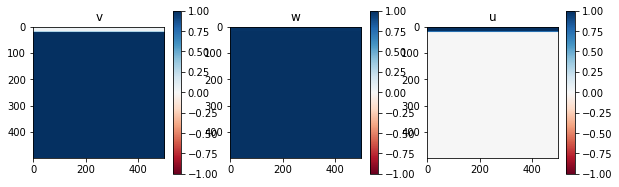

In [7]:
model.show(state)